In [1]:
# SciML Tools
using OrdinaryDiffEq, ModelingToolkit, DataDrivenDiffEq, SciMLSensitivity, DataDrivenSparse
using Optimization, OptimizationOptimisers, OptimizationOptimJL

# Standard Libraries
using LinearAlgebra, Statistics

# External Libraries
using ComponentArrays, Lux, Zygote, Plots, StableRNGs
gr()

# Set a random seed for reproducible behaviour
rng = StableRNG(1111)

StableRNGs.LehmerRNG(state=0x000000000000000000000000000008af)

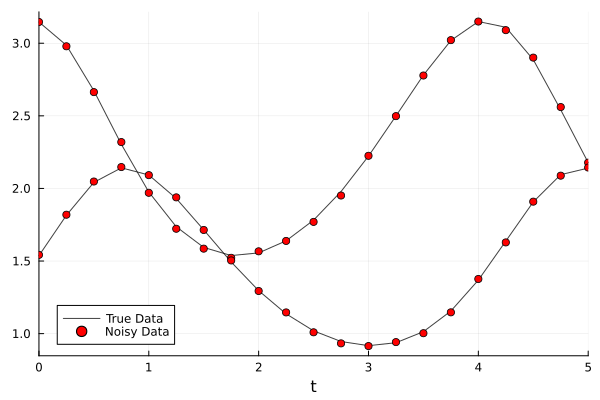

In [2]:
function lotka!(du, u, p, t)
    α, β, γ, δ = p
    du[1] = α * u[1] - β * u[2] * u[1]
    du[2] = γ * u[1] * u[2] - δ * u[2]
end

# Define the experimental parameter
tspan = (0.0, 5.0)
u0 = 5.0f0 * rand(rng, 2)
p_ = [1.3, 0.9, 0.8, 1.8]
prob = ODEProblem(lotka!, u0, tspan, p_)
solution = solve(prob, Vern7(), abstol = 1e-12, reltol = 1e-12, saveat = 0.25)

# Add noise in terms of the mean
X = Array(solution)
t = solution.t

x̄ = mean(X, dims = 2)
noise_magnitude = 5e-3
Xₙ = X .+ (noise_magnitude * x̄) .* randn(rng, eltype(X), size(X))

plot(solution, alpha = 0.75, color = :black, label = ["True Data" nothing])
scatter!(t, transpose(Xₙ), color = :red, label = ["Noisy Data" nothing])

In [3]:
rbf(x) = exp.(-(x .^ 2))

# Multilayer FeedForward
U = Lux.Chain(Lux.Dense(2, 5, rbf), Lux.Dense(5, 5, rbf), Lux.Dense(5, 5, rbf),
              Lux.Dense(5, 2))
# Get the initial parameters and state variables of the model
p, st = Lux.setup(rng, U)

((layer_1 = (weight = Float32[0.49426866 0.5692564; 0.40171918 -0.86652863; … ; 0.47097498 -0.75212044; -0.20216092 -0.31972802], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]), layer_2 = (weight = Float32[0.6822635 -0.69527406 … 0.5011161 0.24313241; -0.39863724 -0.17176461 … -0.61599463 0.18968746; … ; -0.72007084 -0.6787673 … -0.5633968 0.16587467; 0.0014851824 -0.10373303 … 0.090085305 -0.043933477], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]), layer_3 = (weight = Float32[0.0011237671 0.006483868 … 0.27549765 -0.2874395; 0.043832272 -0.32253963 … 0.09472295 -0.42100137; … ; -0.5179172 -0.60432595 … -0.18625909 0.06577149; -0.21508422 0.2565661 … 0.5849693 0.21934992], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]), layer_4 = (weight = Float32[0.71447605 0.43981832 … -0.8286121 0.042569187; -0.56708443 -0.39627415 … 0.16679867 0.8446724], bias = Float32[0.0; 0.0;;])), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple()))

In [4]:
# Define the hybrid model
function ude_dynamics!(du, u, p, t, p_true)
    û = U(u, p, st)[1] # Network prediction
    du[1] = p_true[1] * u[1] + û[1]
    du[2] = -p_true[4] * u[2] + û[2]
end

# Closure with the known parameter
nn_dynamics!(du, u, p, t) = ude_dynamics!(du, u, p, t, p_)
# Define the problem
prob_nn = ODEProblem(nn_dynamics!, Xₙ[:, 1], tspan, p)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 5.0)
u0: 2-element Vector{Float64}:
 3.1463924566781167
 1.5423300037202512

In [5]:
function predict(θ, X = Xₙ[:, 1], T = t)
    _prob = remake(prob_nn, u0 = X, tspan = (T[1], T[end]), p = θ)
    Array(solve(_prob, Vern7(), saveat = T,
                abstol = 1e-6, reltol = 1e-6))
end

predict (generic function with 3 methods)

In [6]:
function loss(θ)
    X̂ = predict(θ)
    mean(abs2, Xₙ .- X̂)
end

loss (generic function with 1 method)

In [7]:
losses = Float64[]

callback = function (p, l)
    push!(losses, l)
    if length(losses) % 50 == 0
        println("Current loss after $(length(losses)) iterations: $(losses[end])")
    end
    return false
end

#1 (generic function with 1 method)

In [8]:
adtype = Optimization.AutoZygote()
optf = Optimization.OptimizationFunction((x, p) -> loss(x), adtype)
optprob = Optimization.OptimizationProblem(optf, ComponentVector{Float64}(p))

OptimizationProblem. In-place: true
u0: ComponentVector{Float64}(layer_1 = (weight = [0.49426865577697754 0.5692564249038696; 0.40171918272972107 -0.8665286302566528; … ; 0.47097498178482056 -0.7521204352378845; -0.20216092467308044 -0.3197280168533325], bias = [0.0; 0.0; … ; 0.0; 0.0;;]), layer_2 = (weight = [0.6822634935379028 -0.6952740550041199 … 0.5011160969734192 0.24313241243362427; -0.39863723516464233 -0.17176461219787598 … -0.6159946322441101 0.18968746066093445; … ; -0.7200708389282227 -0.6787673234939575 … -0.5633968114852905 0.1658746749162674; 0.0014851824380457401 -0.10373303294181824 … 0.09008530527353287 -0.043933477252721786], bias = [0.0; 0.0; … ; 0.0; 0.0;;]), layer_3 = (weight = [0.0011237671133130789 0.006483868230134249 … 0.2754976451396942 -0.2874394953250885; 0.04383227229118347 -0.32253962755203247 … 0.09472294896841049 -0.4210013747215271; … ; -0.5179172158241272 -0.6043259501457214 … -0.18625909090042114 0.06577149033546448; -0.2150842249393463 0.25656610727

In [9]:
res1 = Optimization.solve(optprob, ADAM(), callback = callback, maxiters = 5000)
println("Training loss after $(length(losses)) iterations: $(losses[end])")

Current loss after 50 iterations: 240907.39525614618
Current loss after 100 iterations: 171079.08407144193
Current loss after 150 iterations: 130867.55478466954
Current loss after 200 iterations: 108175.78333021687
Current loss after 250 iterations: 92683.02034637202
Current loss after 300 iterations: 80367.46238861294
Current loss after 350 iterations: 70059.53010465836
Current loss after 400 iterations: 61257.668298399294
Current loss after 450 iterations: 53651.0710184462
Current loss after 500 iterations: 47008.05255933314
Current loss after 550 iterations: 41158.82452107677
Current loss after 600 iterations: 35981.3389191853
Current loss after 650 iterations: 31385.755193845187
Current loss after 700 iterations: 27302.941613633684
Current loss after 750 iterations: 23677.217228629284
Current loss after 800 iterations: 20461.938177565997
Current loss after 850 iterations: 17616.788297450596
Current loss after 900 iterations: 15106.08334544859
Current loss after 950 iterations: 1289

In [10]:
optprob2 = Optimization.OptimizationProblem(optf, res1.u)
res2 = Optimization.solve(optprob2, Optim.LBFGS(), callback = callback, maxiters = 1000)
println("Final training loss after $(length(losses)) iterations: $(losses[end])")

# Rename the best candidate
p_trained = res2.u

Current loss after 5050 iterations: 0.5348983090555166
Current loss after 5100 iterations: 0.5347650782495992
Current loss after 5150 iterations: 0.5333773349668217
Current loss after 5200 iterations: 0.5205469135398304
Current loss after 5250 iterations: 0.4763954268974505
Current loss after 5300 iterations: 0.005942377846288379
Current loss after 5350 iterations: 0.0015884672658415867
Current loss after 5400 iterations: 0.000344373058556662
Current loss after 5450 iterations: 0.0002475595765306416
Current loss after 5500 iterations: 0.00023486479145966546
Current loss after 5550 iterations: 0.0002218089726992527
Current loss after 5600 iterations: 0.00017998968016936967
Current loss after 5650 iterations: 0.00014086250465498626
Current loss after 5700 iterations: 0.00011141702259407502
Current loss after 5750 iterations: 9.628995862342956e-5
Current loss after 5800 iterations: 9.158366357865708e-5
Current loss after 5850 iterations: 8.977596936312392e-5
Current loss after 5900 iterat

ComponentVector{Float64}(layer_1 = (weight = [0.27545557470162396 0.35595201207102795; 0.13745181334571366 -0.6061269903665657; … ; -0.6114507125778582 -1.3669681357995986; -0.9343965425840767 -0.7682476486771923], bias = [-0.4848120756176926; -0.1365748033479632; … ; -0.5343049668020551; -0.08226061241069049;;]), layer_2 = (weight = [1.0732233606040038 -0.7235346459550095 … 0.3106761392796529 0.05326948893409616; 0.1568890764090633 -0.005343654399333514 … -0.21975890175359702 0.13802966671822287; … ; -0.2985796817357532 -1.0045291821150557 … -0.7010453705840457 -0.0710649464239103; 1.6938232997564835 0.30777247968195737 … 0.27657718957854716 0.5959640950776441], bias = [-0.6149166616080136; -0.17166447117232703; … ; -0.518780091609751; 0.43821236254267926;;]), layer_3 = (weight = [0.006985280982894984 -0.07680792786079528 … 0.25062662607955494 -0.598111148512002; 0.3095739654510259 -0.08923593475650805 … 0.32657794889013775 0.006538578228352913; … ; -0.9263592961699645 -0.427123170175

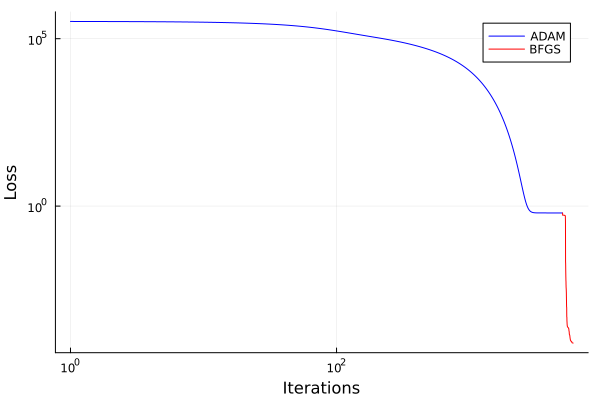

In [11]:
# Plot the losses
pl_losses = plot(1:5000, losses[1:5000], yaxis = :log10, xaxis = :log10,
                 xlabel = "Iterations", ylabel = "Loss", label = "ADAM", color = :blue)
plot!(5001:length(losses), losses[5001:end], yaxis = :log10, xaxis = :log10,
      xlabel = "Iterations", ylabel = "Loss", label = "BFGS", color = :red)

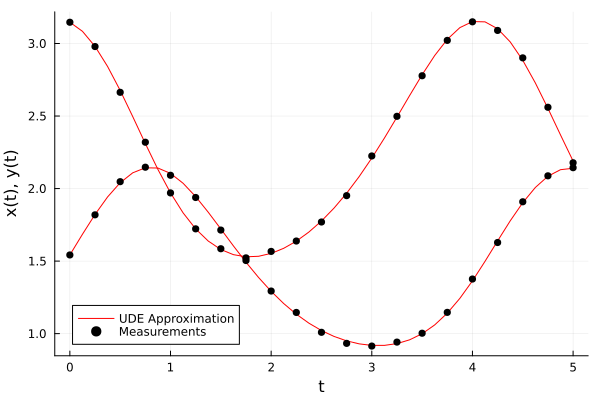

In [12]:
## Analysis of the trained network
# Plot the data and the approximation
ts = first(solution.t):(mean(diff(solution.t)) / 2):last(solution.t)
X̂ = predict(p_trained, Xₙ[:, 1], ts)
# Trained on noisy data vs real solution
pl_trajectory = plot(ts, transpose(X̂), xlabel = "t", ylabel = "x(t), y(t)", color = :red,
                     label = ["UDE Approximation" nothing])
scatter!(solution.t, transpose(Xₙ), color = :black, label = ["Measurements" nothing])

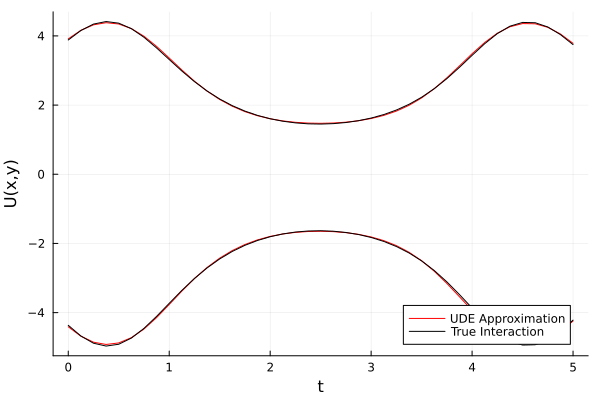

In [13]:
# Ideal unknown interactions of the predictor
Ȳ = [-p_[2] * (X̂[1, :] .* X̂[2, :])'; p_[3] * (X̂[1, :] .* X̂[2, :])']
# Neural network guess
Ŷ = U(X̂, p_trained, st)[1]

pl_reconstruction = plot(ts, transpose(Ŷ), xlabel = "t", ylabel = "U(x,y)", color = :red,
                         label = ["UDE Approximation" nothing])
plot!(ts, transpose(Ȳ), color = :black, label = ["True Interaction" nothing])

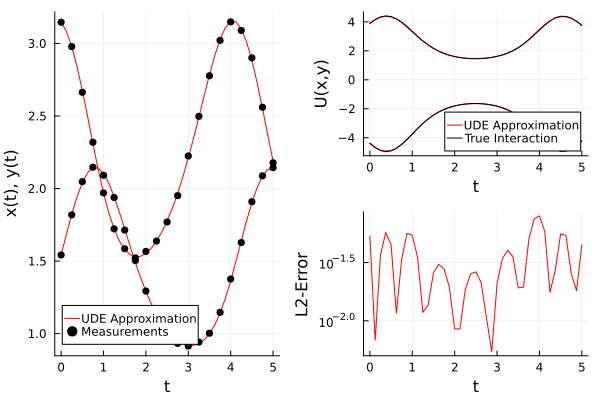

In [14]:
# Plot the error
pl_reconstruction_error = plot(ts, norm.(eachcol(Ȳ - Ŷ)), yaxis = :log, xlabel = "t",
                               ylabel = "L2-Error", label = nothing, color = :red)
pl_missing = plot(pl_reconstruction, pl_reconstruction_error, layout = (2, 1))

pl_overall = plot(pl_trajectory, pl_missing)

## SINDy based regression ##

In [15]:
@variables u[1:2]
b = polynomial_basis(u, 4)
basis = Basis(b, u);

In [16]:
#print basis
basis

Model ##Basis#9540 with 15 equations
States (2):
  u[1]
  u[2]
Parameters (0):

In [17]:
full_problem = ContinuousDataDrivenProblem(Xₙ, t)

Continuous DataDrivenProblem{Float64} ##DDProblem#9543 in 2 dimensions and 21 samples

In [18]:
ideal_problem = DirectDataDrivenProblem(X̂, Ȳ)
nn_problem = DirectDataDrivenProblem(X̂, Ŷ)

Direct DataDrivenProblem{Float64} ##DDProblem#9545 in 2 dimensions and 41 samples

In [19]:
λ = exp10.(-3:0.01:3)
opt = ADMM(λ)

ADMM{Vector{Float64}, Float64}([0.001, 0.0010232929922807535, 0.0010471285480508996, 0.001071519305237606, 0.0010964781961431851, 0.001122018454301963, 0.0011481536214968829, 0.001174897554939529, 0.001202264434617413, 0.0012302687708123812  …  812.8305161640995, 831.7637711026708, 851.1380382023768, 870.9635899560806, 891.2509381337459, 912.0108393559096, 933.2543007969915, 954.992586021436, 977.2372209558112, 1000.0], 1.0)

In [20]:
options = DataDrivenCommonOptions(maxiters = 10_000,
                                  normalize = DataNormalization(ZScoreTransform),
                                  selector = bic, digits = 1,
                                  data_processing = DataProcessing(split = 0.9,
                                                                   batchsize = 30,
                                                                   shuffle = true,
                                                                   rng = StableRNG(1111)))

full_res = solve(full_problem, basis, opt, options = options)
full_eqs = get_basis(full_res)
println(full_res)

┌ Warning: Number of observations less than batch-size, decreasing the batch-size to 19
└ @ MLUtils ~/.julia/packages/MLUtils/NDuSY/src/batchview.jl:95
┌ Warning: Number of observations less than batch-size, decreasing the batch-size to 19
└ @ MLUtils ~/.julia/packages/MLUtils/NDuSY/src/batchview.jl:95


"DataDrivenSolution{Float64}" with 2 equations and 6 parameters.
Returncode: Success
Residual sum of squares: 197.89962654743113


In [21]:
options = DataDrivenCommonOptions(maxiters = 10_000,
                                  normalize = DataNormalization(ZScoreTransform),
                                  selector = bic, digits = 1,
                                  data_processing = DataProcessing(split = 0.9,
                                                                   batchsize = 30,
                                                                   shuffle = true,
                                                                   rng = StableRNG(1111)))

ideal_res = solve(ideal_problem, basis, opt, options = options)
ideal_eqs = get_basis(ideal_res)
println(ideal_res)

"DataDrivenSolution{Float64}" with 2 equations and 2 parameters.
Returncode: Success
Residual sum of squares: 9.860761315262648e-30


In [22]:
options = DataDrivenCommonOptions(maxiters = 10_000,
                                  normalize = DataNormalization(ZScoreTransform),
                                  selector = bic, digits = 1,
                                  data_processing = DataProcessing(split = 0.9,
                                                                   batchsize = 30,
                                                                   shuffle = true,
                                                                   rng = StableRNG(1111)))

nn_res = solve(nn_problem, basis, opt, options = options)
nn_eqs = get_basis(nn_res)
println(nn_res)

"DataDrivenSolution{Float64}" with 2 equations and 4 parameters.
Returncode: Success
Residual sum of squares: 209.99394106291632


In [23]:
for eqs in (full_eqs, ideal_eqs, nn_eqs)
    println(eqs)
    println(get_parameter_map(eqs))
    println()
end

Model ##Basis#9546 with 2 equations
States : u[1] u[2]
Parameters : 6
Independent variable: t
Equations
Differential(t)(u[1]) = p₁*(u[1]^2) + p₂*u[2] + p₄*(u[2]^4) + p₃*(u[2]^3)*u[1]
Differential(t)(u[2]) = p₅*(u[1]^2) + p₆*u[2]

Pair{SymbolicUtils.BasicSymbolic{Real}, Float64}[p₁ => 0.4, p₂ => -0.3, p₃ => 0.1, p₄ => -0.1, p₅ => 0.1, p₆ => -1.0]

Model ##Basis#9550 with 2 equations
States : u[1] u[2]
Parameters : p₁ p₂
Independent variable: t
Equations
φ₁ = p₁*u[1]*u[2]
φ₂ = p₂*u[1]*u[2]

Pair{SymbolicUtils.BasicSymbolic{Real}, Float64}[p₁ => -0.9, p₂ => 0.8]

Model ##Basis#9554 with 2 equations
States : u[1] u[2]
Parameters : p₁ p₂ p₃ p₄
Independent variable: t
Equations
φ₁ = p₁ + p₂*u[1]*u[2]
φ₂ = p₃ + p₄*u[1]*u[2]

Pair{SymbolicUtils.BasicSymbolic{Real}, Float64}[p₁ => -0.8, p₂ => -0.3, p₃ => 0.8, p₄ => 0.2]



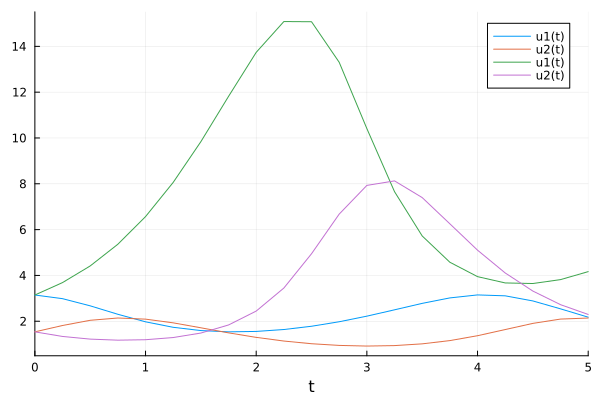

In [24]:
# Define the recovered, hybrid model
function recovered_dynamics!(du, u, p, t)
    û = nn_eqs(u, p) # Recovered equations
    du[1] = p_[1] * u[1] + û[1]
    du[2] = -p_[4] * u[2] + û[2]
end

estimation_prob = ODEProblem(recovered_dynamics!, u0, tspan, get_parameter_values(nn_eqs))
estimate = solve(estimation_prob, Tsit5(), saveat = solution.t)

# Plot
plot(solution)
plot!(estimate)

In [25]:
function parameter_loss(p)
    Y = reduce(hcat, map(Base.Fix2(nn_eqs, p), eachcol(X̂)))
    sum(abs2, Ŷ .- Y)
end

optf = Optimization.OptimizationFunction((x, p) -> parameter_loss(x), adtype)
optprob = Optimization.OptimizationProblem(optf, get_parameter_values(nn_eqs))
parameter_res = Optimization.solve(optprob, Optim.LBFGS(), maxiters = 1000)

u: 4-element Vector{Float64}:
 -0.0023017586436216986
 -0.8995428580056817
  0.0015178357696080669
  0.8006145454901763

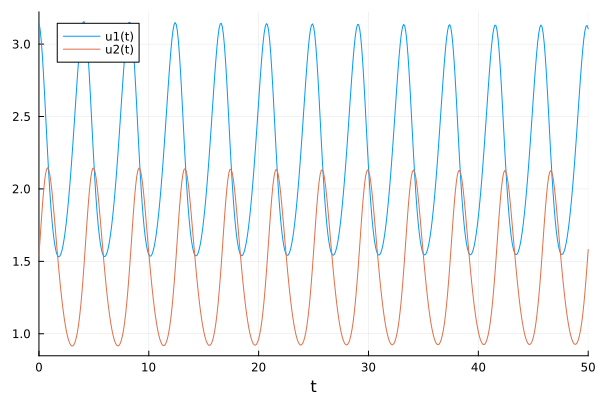

In [26]:
# Look at long term prediction
t_long = (0.0, 50.0)
estimation_prob = ODEProblem(recovered_dynamics!, u0, t_long, parameter_res)
estimate_long = solve(estimation_prob, Tsit5(), saveat = 0.1) # Using higher tolerances here results in exit of julia
plot(estimate_long)

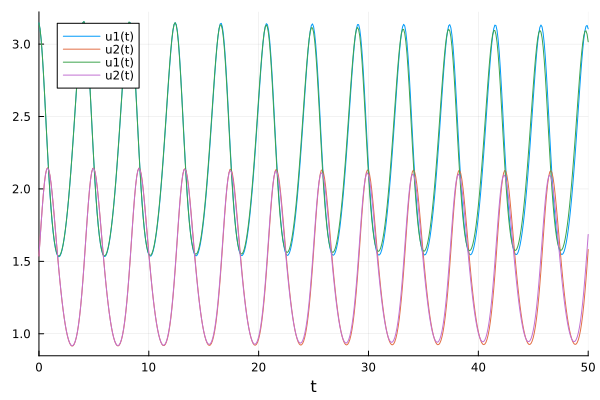

In [27]:
true_prob = ODEProblem(lotka!, u0, t_long, p_)
true_solution_long = solve(true_prob, Tsit5(), saveat = estimate_long.t)
plot!(true_solution_long)

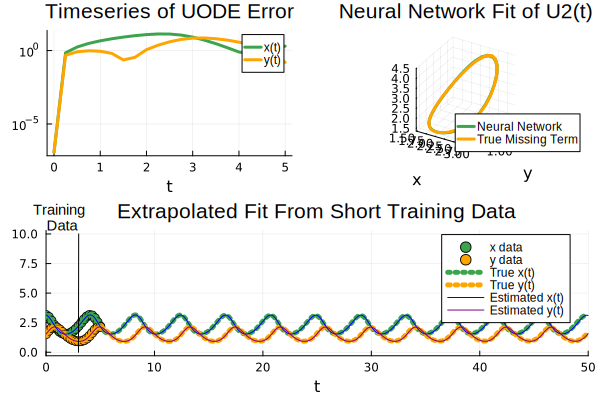

In [28]:
c1 = 3 # RGBA(174/255,192/255,201/255,1) # Maroon
c2 = :orange # RGBA(132/255,159/255,173/255,1) # Red
c3 = :blue # RGBA(255/255,90/255,0,1) # Orange
c4 = :purple # RGBA(153/255,50/255,204/255,1) # Purple

p1 = plot(t, abs.(Array(solution) .- estimate)' .+ eps(Float32),
          lw = 3, yaxis = :log, title = "Timeseries of UODE Error",
          color = [3 :orange], xlabel = "t",
          label = ["x(t)" "y(t)"],
          titlefont = "Helvetica", legendfont = "Helvetica",
          legend = :topright)

# Plot L₂
p2 = plot3d(X̂[1, :], X̂[2, :], Ŷ[2, :], lw = 3,
            title = "Neural Network Fit of U2(t)", color = c1,
            label = "Neural Network", xaxis = "x", yaxis = "y",
            titlefont = "Helvetica", legendfont = "Helvetica",
            legend = :bottomright)
plot!(X̂[1, :], X̂[2, :], Ȳ[2, :], lw = 3, label = "True Missing Term", color = c2)

p3 = scatter(solution, color = [c1 c2], label = ["x data" "y data"],
             title = "Extrapolated Fit From Short Training Data",
             titlefont = "Helvetica", legendfont = "Helvetica",
             markersize = 5)

plot!(p3, true_solution_long, color = [c1 c2], linestyle = :dot, lw = 5,
      label = ["True x(t)" "True y(t)"])
plot!(p3, estimate_long, color = [c3 c4], lw = 1,
      label = ["Estimated x(t)" "Estimated y(t)"])
plot!(p3, [2.99, 3.01], [0.0, 10.0], lw = 1, color = :black, label = nothing)
annotate!([(1.5, 13, text("Training \nData", 10, :center, :top, :black, "Helvetica"))])
l = @layout [grid(1, 2)
             grid(1, 1)]
plot(p1, p2, p3, layout = l)